# Splice-junction Gene Sequences Data Set 


In [1]:

#Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import csv
import collections
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import time
from datetime import timedelta
import math
import cv2
import matplotlib.gridspec as gridspec
import os
import random

### DataSet 
Here I am loading the dataset and shuffling it as same classes are next to each other. After shuffling the data I am splitting them into label and data. Then it is divided into training, validation and test sets.

In [2]:
#Loading the dataset
dataFile="./splice.data"
with open(dataFile,mode='r') as f:
    fileData=f.read()
#File Parameters
lineLength=100
totalLines=len(fileData)//lineLength
numClasses=3
#Splitting dataset into lines
dataLines=[]
for lineCounter in range(totalLines):
    line=fileData[(lineCounter*lineLength):(lineCounter*lineLength)+lineLength]
    dataLines.append(line)
assert(len(dataLines)==totalLines)

In [3]:
#All class examples are next to each other. So shuffling the list of dataLines
from random import shuffle
shuffle(dataLines)
totalLabels=[]
totalData=[]
#Splitting lines into data and labels
for line in range(totalLines):
    label,instance,data=dataLines[line].split()
    label=label.split(",")
    label=label[0]
    totalLabels.append(label)
    totalData.append(data)
assert(len(totalLabels)==totalLines)
assert(len(totalData)==totalLines)
dataLength=len(totalData[0])

In [4]:
#Convert totalData into onehot encoded images
numDnaLtrs=8
def dnaSeq2Vector(line):
    dnaLtrDict={"G":[0,0,0,0,0,0,0,1],
                "N":[0,0,0,0,0,0,1,0],
                "C":[0,0,0,0,0,1,0,0],
                "S":[0,0,0,0,1,0,0,0],
                "A":[0,0,0,1,0,0,0,0],
                "D":[0,0,1,0,0,0,0,0],
                "T":[0,1,0,0,0,0,0,0],
                "R":[1,0,0,0,0,0,0,0]}
    return np.asarray([dnaLtrDict[letter] for letter in line])
totalDataArr=np.zeros((totalLines,dataLength,numDnaLtrs))
for line in range(totalLines):
    totalDataArr[line]=dnaSeq2Vector(totalData[line])

In [5]:
testSize=0.2
valSize=0.2
testSplitDone=False
valSplitDone=False

In [6]:
#Split into train,validation and test data
from sklearn.cross_validation import train_test_split
trainData0Split=np.zeros(shape=[totalLines*(1-testSize),dataLength,numDnaLtrs])
testData=np.zeros(shape=[totalLines*testSize,dataLength,numDnaLtrs])
if(testSplitDone==False):
    testSplitDone=True
    trainData0Split,testData,trainLabels0Split,testLabels=train_test_split(
                totalDataArr,totalLabels,test_size=testSize)
assert((len(trainData0Split)+len(testData))==len(totalDataArr))
#Splitting training data into val and train data
trainData=np.zeros(shape=[totalLines*(1-testSize-valSize),dataLength,numDnaLtrs])
valData=np.zeros(shape=[totalLines*(1-valSize),dataLength,numDnaLtrs])
if(valSplitDone==False):
    valSplitDone=True
    trainData,valData,trainLabels,valLabels=train_test_split(
                trainData0Split,trainLabels0Split,test_size=valSize,random_state=2)
assert((len(trainData)+len(testData)+len(valData))==len(totalDataArr))

/home/krishna/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/krishna/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/krishna/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/krishna/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
#Convert labels into numbers
labelDict={"EI":0,
           "IE":1,
           "N" :2}
def convLabels(Label):
    return [labelDict[letter] for letter in Label]
trainLabelsConv=np.asarray(convLabels(trainLabels))
testLabelsConv=np.asarray(convLabels(testLabels))
valLabelsConv=np.asarray(convLabels(valLabels))

In [8]:
from sklearn.preprocessing import OneHotEncoder
def LabelEncoder(Labels,NumLabels):
    """Takes in Normal labels and returns onehot encoded labels"""
    Encoder=OneHotEncoder()
    Encoder.fit(np.arange(NumLabels).reshape(-1,1))
    EncodedLabels=Encoder.transform(Labels.reshape(-1,1)).toarray()
    return EncodedLabels
TrainLabelsOHE=LabelEncoder(trainLabelsConv,numClasses)
ValLabelsOHE  =LabelEncoder(valLabelsConv,numClasses)
TestLabelsOHE =LabelEncoder(testLabelsConv,numClasses)

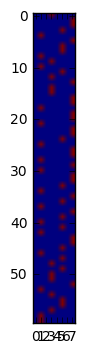

In [9]:
plt.imshow(trainData[0])

In [10]:
#Helper Functions for CNN Layers
wname1=0
wname2=100
def CreateConvLayer(input,NumChnls,FilSize,NumFils,Stride=1,pooling=True):
    global wname1
    #Create shape of filter
    FilterShape=[FilSize,FilSize,NumChnls,NumFils]
    #Create variables for weights and Biases
    wname1=wname1+1
    Weights=tf.get_variable("Weights"+str(wname1),
                            shape=FilterShape,initializer=tf.contrib.layers.xavier_initializer())
    Biases=tf.Variable(tf.constant(0.05,shape=[NumFils]))
    #Convolution Output
    ConvOpt=tf.nn.conv2d(input=input,filter=Weights,strides=[1,Stride,Stride,1],padding='SAME')
    #Add ConvOpt to Biases
    LayerOpt=tf.nn.bias_add(ConvOpt,Biases)
    #MaxPooling
    if(pooling==True):
        LayerOpt=tf.nn.max_pool(LayerOpt,[1,2,2,1],[1,2,2,1],'SAME')
    #Perform Relu
    LayerOpt=tf.nn.relu(LayerOpt)
    return LayerOpt,Weights
#Flatten Layer to input to Fully Connected Layer
def FlattenLayer(layer):
    LayerShape=layer.get_shape()
    NumFeatures =LayerShape[1:4].num_elements()
    LayerFlat=tf.reshape(layer,[-1,NumFeatures])
    return LayerFlat,NumFeatures
#Fully Connected Layer
def CreateFCLayer(input,NumInputs,NumOutputs,relu=True):
    global wname2
    #Weight Shape
    WShape=[NumInputs,NumOutputs]
    #Create Variables for Weights and Biases
    wname2=wname2+1
    Weights=tf.get_variable("Weights"+str(wname2),
                            shape=WShape,initializer=tf.contrib.layers.xavier_initializer())
    Biases=tf.Variable(tf.constant(0.05,shape=[NumOutputs]))
    #Calculate FC
    FCLayer=tf.matmul(input,Weights)+Biases
    if(relu==True):
        FCLayer=tf.nn.relu(FCLayer)
    return FCLayer, Weights

In [11]:
def seqCNN(x,dropVal):
    FilterSize=[4,4]
    NumFilters=[16,32]
    FCSize=[64,32]
    #Layer1
    L1Conv, L1ConvWeight=CreateConvLayer(x,1,FilterSize[0],NumFilters[0])
    #Layer2
    L2Conv, L2ConvWeight =CreateConvLayer(L1Conv,NumFilters[0],FilterSize[1],NumFilters[1])  
    FCFlat, NumFeatures=FlattenLayer(L2Conv)
    FC1,FC1W=CreateFCLayer(FCFlat,NumFeatures,FCSize[0])
    FC1=tf.nn.dropout(FC1,dropVal)
    FC2,FC2W=CreateFCLayer(FC1,FCSize[0],FCSize[1])
    FC2=tf.nn.dropout(FC2,dropVal)
    FC5,FC5W=CreateFCLayer(FC2,FCSize[1],numClasses,relu=False)
    return L1ConvWeight,L2ConvWeight,FC1W,FC2W,FC5W,FC5

In [12]:
ImgPHFlat=tf.placeholder(tf.float32,[None,dataLength,numDnaLtrs])
ImgPHRS=tf.reshape(ImgPHFlat,[-1,dataLength,numDnaLtrs,1])
#Placeholders for Labels
LabelPH_OHE  =tf.placeholder(tf.float32,[None,numClasses])
LabelPH_Plain=tf.placeholder(tf.float32,[None])
#Placeholder for avoiding dropout during inference
DropVal1=tf.placeholder(tf.float32)

In [13]:
#Running through network
L1ConvWeight,L2ConvWeight,FC1W,FC2W,FC5W,NetworkOpt=seqCNN(ImgPHRS,dropVal=DropVal1)
#Applying Softmax to predict
ClassPredOHE = tf.nn.softmax(NetworkOpt)
#Selecting the highest probability to get normal label
ClassPred    = tf.argmax(ClassPredOHE, dimension=1)
#Casting
ClassPred    = tf.cast(ClassPred,tf.float32)

In [14]:
CrossEntorpy = tf.nn.softmax_cross_entropy_with_logits(logits=NetworkOpt,labels=LabelPH_OHE)
Cost = tf.reduce_mean(CrossEntorpy)
Optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(Cost)

In [15]:
#Accuracy
CorrectPred = tf.equal(ClassPred,LabelPH_Plain)
Accuracy = tf.reduce_mean(tf.cast(CorrectPred, tf.float32))

In [16]:
#Initialization
session=tf.Session()
session.run(tf.global_variables_initializer())


In [17]:
TotalRuns=0
BestValAcc=0.0
def TrainCNN(NumRuns,BatchSize):
    print("Training Started")
    global TotalRuns
    global BestValAcc    
    #Keep track of time to report at last
    StartTime=time.time()
    for i in range(TotalRuns,TotalRuns+NumRuns):
        TotalRuns=TotalRuns+1
        #Choose BatchSize number of indices randomly without replacement
        TrainIndex=np.random.choice(len(trainData),BatchSize,replace=False)
        #Dictionary for Optimizer
        TrainDict= {
            ImgPHFlat:trainData[TrainIndex,:],
            DropVal1:0.5,
            LabelPH_OHE:TrainLabelsOHE[TrainIndex,:]
        }
        #Running Optimizer
        session.run(Optimizer,TrainDict)
        #Dictionary for Calculating Training accuracy of this batch
        TrainAccDict={
            ImgPHFlat:trainData[TrainIndex,:],
            DropVal1:1,
            LabelPH_OHE:TrainLabelsOHE[TrainIndex,:],
            LabelPH_Plain:trainLabelsConv[TrainIndex]
        }
        #For Every 500 Iterations give accuracy
        if ((TotalRuns%50==0) or (i==(NumRuns-1))):
            #Calculate Training Accuracy
            TrainAcc=session.run(Accuracy,TrainAccDict)
            ValAcc=CalAcc("Val",BatchSize)
            TestAcc=CalAcc("Test",BatchSize)
            #Saving good stuff
            if (ValAcc>=BestValAcc):
                BestValAcc=ValAcc
                #saver.save(sess=session,save_path=SaveDir)
                ImpStr="*"
            else:
                ImpStr=" "
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3} Test Acc:{4:>4.1%}"
            print(msg.format(i + 1,TrainAcc,ValAcc,ImpStr,TestAcc))
    #Ending and reporting results
    EndTime=time.time()
    TimeDelta=EndTime-StartTime
    print("Total Time ="+str(timedelta(seconds=int(round(TimeDelta)))))

In [18]:
print(len(trainData))

2041


In [19]:
def CalAcc(Type="Val",BatchSize=100):
    AccuracyVal=0
    if(Type=="Val"):
        ValIndex=np.random.choice(len(valData),BatchSize,replace=False)
        ValAccDict={
            ImgPHFlat:valData[ValIndex,:],
            DropVal1:1,            
            LabelPH_OHE:ValLabelsOHE[ValIndex,:],
            LabelPH_Plain:valLabelsConv[ValIndex]            
        }
        AccuracyVal=session.run(Accuracy,ValAccDict)
    if(Type=="Test"):
        TestIndex=np.random.choice(len(testData),BatchSize,replace=False)
        TestAccDict={
            ImgPHFlat:testData[TestIndex,:],
            DropVal1:1,
            LabelPH_OHE:TestLabelsOHE[TestIndex,:],
            LabelPH_Plain:testLabelsConv[TestIndex]            
        }
        AccuracyVal=session.run(Accuracy,TestAccDict)
    return AccuracyVal

In [20]:
TrainCNN(2500,500)

Training Started
Iter:     50, Train-Batch Accuracy:  52.8%, Validation Acc:  52.4% * Test Acc:53.2%
Iter:    100, Train-Batch Accuracy:  53.4%, Validation Acc:  52.2%   Test Acc:54.4%
Iter:    150, Train-Batch Accuracy:  53.0%, Validation Acc:  53.6% * Test Acc:54.6%
Iter:    200, Train-Batch Accuracy:  68.2%, Validation Acc:  62.0% * Test Acc:60.4%
Iter:    250, Train-Batch Accuracy:  73.2%, Validation Acc:  70.0% * Test Acc:66.4%
Iter:    300, Train-Batch Accuracy:  75.4%, Validation Acc:  73.6% * Test Acc:72.0%
Iter:    350, Train-Batch Accuracy:  84.2%, Validation Acc:  80.2% * Test Acc:82.4%
Iter:    400, Train-Batch Accuracy:  86.6%, Validation Acc:  83.6% * Test Acc:85.8%
Iter:    450, Train-Batch Accuracy:  90.0%, Validation Acc:  88.4% * Test Acc:90.6%
Iter:    500, Train-Batch Accuracy:  90.8%, Validation Acc:  89.8% * Test Acc:89.0%
Iter:    550, Train-Batch Accuracy:  90.4%, Validation Acc:  90.2% * Test Acc:90.4%
Iter:    600, Train-Batch Accuracy:  92.8%, Validation Acc:

In [24]:
labels={0:"EI",1:"IE",2:"N"}
def TestDnaSplice(str2test):
    testString=dnaSeq2Vector(str2test)
    TestDict={
            ImgPHFlat:[testString,testString],
            DropVal1:1,
            LabelPH_OHE:TestLabelsOHE
        }
    Val=session.run(ClassPred,TestDict)
    Val=Val.astype(int)
    print(labels[Val[0]])


NameError: name 'labelDict' is not defined